# Basic implementation of DAISY descriptor

## DAISY Algorithm
DAISY samples the local gradient information as shown in a figure below. Each circle represents a region where the radius is proportional to the standard deviations of the Gaussian kernels. Dots represents locations where the Convolved Orientation Maps (COMs) are sampled.

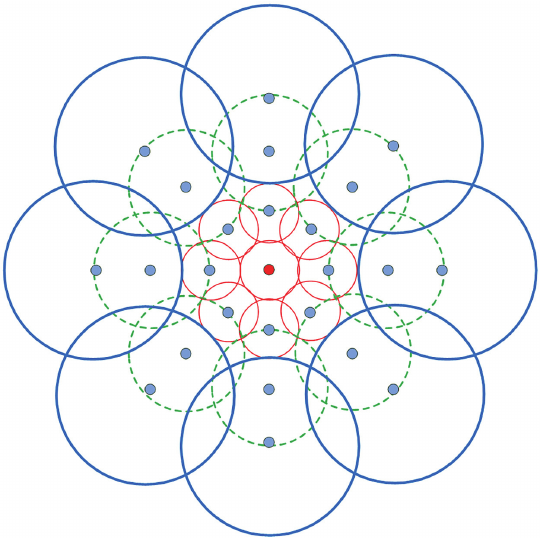

Each circle represents one histogram region, which is part of the descriptor vector. Each histogram represents the Gradient Orientations (GOs) within this region. The gradient is split into $H$ discrete orientations, so each single histogram has $H$ entries.

Algortihm uses $Q$ rings around the central point, on which the COMs are sampled, each ring has $T$ histograms.

Therefore, each descriptor has $D_s=(Q \centerdot T+1)\centerdot H$ entries.

To compute GOs at a specified point $(u,v)$, several oriented derivatives of image $I$ are computed as following:

$$G_o^\sigma = G^\sigma * \left(\dfrac{dI}{do}\right)^+ , \left(\dfrac{dI}{do}\right)^+ = max\left(\dfrac{dI}{do}, 0\right),$$
where $ G^\sigma $ is a Gaussian kernel with standard deviation $ \sigma $ and $o$ is a derivative orientation.

The results $G_o^{\sigma}$ are referred as Convolved Orientation Maps (COMs).

In the next step the vector $h_\sigma(u,v)$ is being built as following:

$$h_\sigma(u,v) = \left[G_1^\sigma(u,v), \dots, G_H^\sigma(u,v)\right]^T$$

Vector $h(u,v)$ is then normalized to unit norm. It represents the values of all the GOs at a point $(u,v)$ after convolution with a Gaussian kernel with a standard deviation $\sigma$.

The full DAISY descriptor for location $(u_0,v_0)$ is defined as a simple concatenation of all the vectors $h_{\sigma i}(u,v)$ for all points beginning with the center:

$$D(u_0,v_0) = [h_{\sigma 1}(u_0, v_0), h_{\sigma 1}(I_1(u_0, v_0, R_1)), \dots, h_{\sigma 1}(I_T(u_0, v_0, R_1),$$ 
$$h_{\sigma 2}(I_1(u_0, v_0, R_2)), \dots, h_{\sigma 2}(I_T(u_0, v_0, R_2),$$
$$\dots \dots$$
$$h_{\sigma Q}(I_1(u_0, v_0, R_Q)), \dots, h_{\sigma Q}(I_T(u_0, v_0, R_Q)],$$

where $I_j(u, v, R)$ is the location with distance $R$ from $(u, v)$ in the direction given by $j$
when the directions are quantized into the $T$ values.

In [31]:
import numpy as np

from skimage import data
from skimage.color import rgb2gray
from skimage.filters import sobel_h, sobel_v, gaussian
from skimage.feature import match_descriptors
from skimage.exposure import rescale_intensity
from skimage.util import img_as_float, img_as_ubyte
from skimage import transform
from sklearn import preprocessing

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sb


from skimage.draw import (line, circle_perimeter)
from enum import Enum

%matplotlib inline 


## DAISY implementation
Next function computes a single Gradient Orientation Map. As image derivative we use a Sobel filter.
Standard edge-detection filter can work only in $x$ or $y$ axis.
However, method, known as steerable filter, allows us to compute derivative at any virtual axis $z$ at some angle $\theta$:
$$d_z = \left(d_x \cos\theta + d_y \sin\theta\right)^+$$

In [2]:
# Computes a Gradient Orientation Map on derivative axis
# with angle tetha
def gradient_orientation(image, tetha):
    # Steering filter - combination of X and Y derivatives 
    # to det a derivative on a specific angle
    d_hor = sobel_h(image)
    d_ver = sobel_v(image)
    derivative = d_hor * np.cos(tetha) + d_ver * np.sin(tetha)
    # Operator max(d, 0) levaes only positive derivative
    derivative = derivative.clip(min=0)
    return derivative

Next function computes a set of GO's for a given number of directions. Directions are arranged evenly in a circle.

In [3]:
# Compute GOs for a number of directions
def compute_global_orientation_maps(image, H):
    tetha_step = 2 * np.pi / H
    result = []
    for k in range(0, H):
        tetha = tetha_step * k
        result.append(gradient_orientation(image, tetha))
    return result

Next function convolves a set of GO's with several Gaussian kernels to produce Convolved Orientation Maps for each level of Gaussian standard deviation $\sigma$.

In [4]:
# Convolves orientation maps with Gaussian
# kernels with specified standard deviations
def convolve_orientation_maps(gos, sigmas):
    result = []
    for sigma in sigmas:
        conv = []
        for go in gos:
            conv.append(gaussian(go, sigma))
        result.append(conv)
    return result

DAISY descriptor can be normalized in several different manners:
* No normalization at all
* Normalizing each $h$ vector to unit norm separately
* Normalazing full descriptor to unit norm
* SIFT-style full descriptor normalization with no individual element bigger than 0.154 and sum equals to 1

In [5]:
class NormType(Enum):
    NRM_NONE = 1
    NRM_PARTIAL = 2 
    NRM_FULL = 3
    NRM_SIFT_STYLE = 4

Here is the main DAISY function. For illustrative purposes, we compute only one descriptor, at the specified point of the image. Function returns descriptor vector $Ds$, visualization of a DAISY pattern, and a set of computed COM's to illustrate it's work.

In [6]:
# Calculation of a single DAISY descriptor for a given point of an image
def daisy(image, center, R, Q, T, H, sigmas, norm=NormType.NRM_NONE):
    
    # Setting steps in angle and radius
    tetha_step = 2 * np.pi / T
    radius_step = float(R) / Q
    # Calculating total number of entries in a descriptor
    Ds = (Q*T+1)*H
    descriptor = np.zeros((1, Ds))
    
    # Copy of image for visualization
    visualize = np.copy(image)
    
    # Compute GOs
    gradient_orientations = compute_global_orientation_maps(image, H)
    # Convolve GOs with Gaussian kernels to get COMs
    conv_orient_maps = convolve_orientation_maps(gradient_orientations, sigmas)
    
    # Sampling vectors from COMs at DAISY points
    # Center point
    h = sample_h_vector(center[0], center[1], conv_orient_maps[0], visualize, sigmas[0])
    descriptor[0, 0:H] = h
    # Sample the rest of the points in DAISY pattern
    for i in range(0, Q):
        r = (i+1) * radius_step
        maps = conv_orient_maps[i]
        for j in range(0, T):
            tetha = j * tetha_step
            x = int(center[0] + r * np.cos(tetha))
            y = int(center[1] + r * np.sin(tetha))
            
            h = sample_h_vector(x, y, maps, visualize, sigmas[i+1])
            # Normalization for partial norm type
            if norm == NormType.NRM_PARTIAL:
                h = preprocessing.normalize(h.reshape((1, -1)), norm='l2')

            idx_start = ((i)*T+j)*H+H
            idx_end = ((i)*T+j)*H+2*H
            descriptor[0, idx_start:idx_end] = h
    
    # Normalization for full norm type
    if norm == NormType.NRM_FULL:
        descriptor = preprocessing.normalize(descriptor.reshape((1, -1)), norm='l2')
    # Normalization for SIFT-style norm
    if norm == NormType.NRM_SIFT_STYLE:
        descriptor = preprocessing.normalize(descriptor.reshape((1, -1)), norm='l2')
        descriptor = descriptor.clip(max=0.154)
        descriptor /= descriptor.sum()
        
    return descriptor, visualize, gradient_orientations, conv_orient_maps

# Samples the single h vector at point 
def sample_h_vector(x, y, maps, visualize, sigma):
    # Sampling the vector
    h = np.zeros(H)
    for k in range(0, H):
        h[k] = maps[k][x, y]
    # Visualize the point
    draw_circle(visualize, x, y, sigma)
    draw_lines(visualize, x, y, sigma, H)
    return h

#### Utility functions
Functions for data visualization

In [95]:
# Draws a circle
def draw_circle(image, x, y, radius):
    rr, cc = circle_perimeter(x, y, radius)
    image[rr, cc] = 1

# Draws a set of evenly arranged lines from center
def draw_lines(image, x, y, radius, n):
    tetha_step = 2 * np.pi / n
    for i in range(0, n):
        tetha = i * tetha_step
        line_len = int(radius * 0.7)
        x1 = int(x + line_len * np.sin(tetha))
        j1 = int(y + line_len * np.cos(tetha))
        rr, cc = line(x, y, x1, j1)
        image[rr, cc] = 1
    
# Shows an image
def imgshow(image, title='', cmap=plt.cm.gray):
    fig, ax = plt.subplots()
    ax.imshow(img_as_ubyte(image), cmap=cmap)
    ax.set_title(title)
    plt.show()

# Shows a set of images in a grid 
def show_maps(maps, title=''):
    grid_i = 2
    grid_j = int(np.ceil(len(maps) / 2))
    fig, ax = plt.subplots(grid_i, grid_j)
    fig.suptitle(title)
    for i in range(0, grid_i):
        for j in range(0, grid_j):
            idx = i*grid_j+j
            if(idx >= len(maps)):
                break
            ax[i, j].set_title(idx)
            ax[i, j].imshow(maps[idx], cmap = plt.cm.plasma)
    plt.tight_layout()

# Simple XY 2d plot
def plot_xy(x, y, title='', xlabel='', ylabel=''):
    fig, ax = plt.subplots()
    ax.plot(x, y)
    ax.grid()
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    plt.tight_layout()
    plt.show()

## Test data preparation
We use a 128 * 128 sample of a contrast grayscale image from skimage.data

(512, 512)


/opt/conda/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


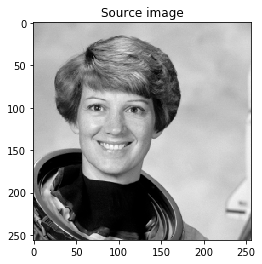

Image size:(256, 256)


In [131]:
img_src = rgb2gray(img_as_float(data.astronaut()))

print(img_src.shape)

#center = [img_src.shape[1] / 2, img_src.shape[0] / 2]
center = [128, 256]
size = [256, 256]

image = img_src[int(center[0]-size[0] / 2):int(center[0]+size[0] / 2), 
           int(center[1]-size[1] / 2):int(center[1]+size[1] / 2)]
imgshow(image, 'Source image')
print(f'Image size:{image.shape}')

## Testing section 
Here is the list of modifiable parameters:
* Maximum radius $R$
* Number of rings $Q$
* Number of points per ring $T$
* Number of histograms per point $H$
* Gaussian filter standard deviations $\sigma$ for each ring
* Normalization type

**Notice that big sigma values or radius may result in index out of bounds exception!** 

In [155]:
R = 30
Q = 2
T = 8
H = 8
SIGMAS = [5, 10, 25]
NORM = NormType.NRM_SIFT_STYLE

/opt/conda/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


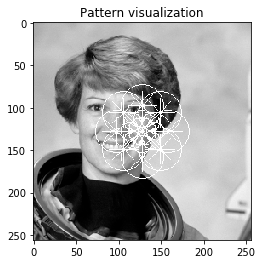

In [156]:
# Computing one descriptor at the center of the image
x, y = image.shape
point = [int(x/2), int(y/2)]

descriptor, visualize, gradient_orientations, coms = daisy(image, point, R, Q, T, H, SIGMAS, NORM)
imgshow(visualize, title='Pattern visualization')

Here we can explore the algorithm data. Let's check gradient orientation maps:

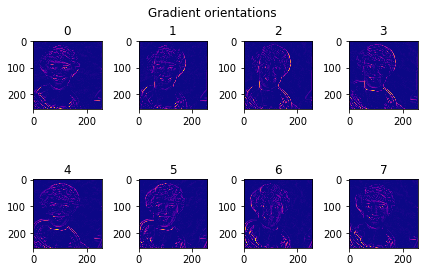

In [151]:
show_maps(gradient_orientations, title='Gradient orientations')

The convolved orientation maps for each ring:

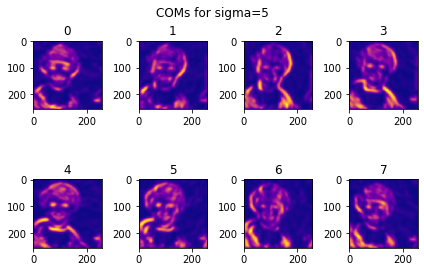

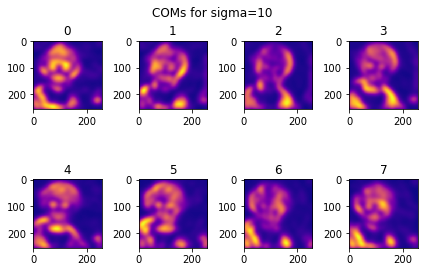

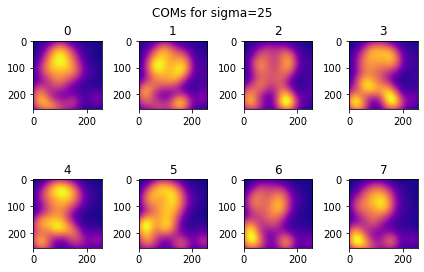

In [152]:
for i in range(len(SIGMAS)):
    show_maps(coms[i], title=f'COMs for sigma={SIGMAS[i]}')

### Resulting descriptor
Resulting descriptor vector is consists of $D_s$ elements:

In [153]:
print(descriptor, '\n')
print(f'Descriptor magnitude: {np.linalg.norm(descriptor)}')
print(f'Descriptor sum: {descriptor.sum()}')

[[0.01283271 0.00920022 0.01564152 0.02363477 0.05744573 0.11090399
  0.11485935 0.0622462  0.0415405  0.06048229 0.05738497 0.027378
  0.03542321 0.11049699 0.13423373 0.08604386 0.11259888 0.1766622
  0.1475533  0.07255696 0.01807322 0.04190732 0.05150678 0.07148155
  0.17453538 0.16327776 0.08557783 0.01459293 0.01872695 0.07703708
  0.11942352 0.14869864 0.0274175  0.01359234 0.00829255 0.00484408
  0.03229393 0.15884454 0.20883373 0.14319995 0.11383114 0.06737793
  0.02897715 0.01585596 0.01986987 0.04942419 0.097548   0.13078351
  0.04772972 0.04248485 0.05070344 0.05453354 0.03610309 0.01709648
  0.02642549 0.0455877  0.03313089 0.05206384 0.11466642 0.13227143
  0.09482675 0.03272265 0.02561799 0.02567913 0.10798404 0.1455525
  0.13744039 0.10833667 0.10366841 0.08441848 0.05529947 0.05330588
  0.04688762 0.09677265 0.1025411  0.06062984 0.0538475  0.07310767
  0.06211389 0.02712211 0.03691402 0.05682787 0.0483732  0.02233571
  0.01126541 0.01773024 0.01872942 0.01951069 0.1100

## Testing descriptor invariancy to image transformations
From here we will test descriptors invariancy to image transformations, such as rotation, scale, and contrast.
### Testing effects of rotation
Let's start with rotation. We will rotate image by certain angle up to 360$^\circ$, and on each step compare descriptor for it's center point with initial by calculating mean squared error.

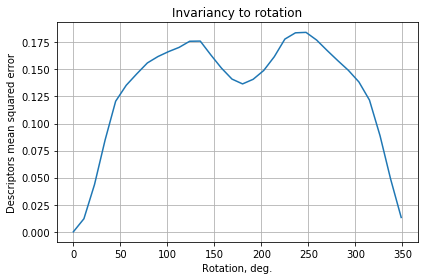

In [161]:
n = 32
tethas = np.zeros(n)
mean_stds = np.zeros(n)
tetha_step = 360 / n

point2 = [point[0], point[1]]

for i in range(0, n):
    tetha = i * tetha_step
    image2 = transform.rotate(image, tetha)
    descriptor2, visualize2, gradient_orientations2, coms2 = daisy(image2, point2, R, Q, T, H, SIGMAS, NORM)
    desc_norm = max(np.max(descriptor), np.max(descriptor2))
    mean_stds[i] = (((descriptor - descriptor2) / desc_norm) ** 2).mean()
    tethas[i] = tetha
    #imgshow(visualize2)
    
plot_xy(tethas, mean_stds, 
        title='Invariancy to rotation', 
        xlabel='Rotation, deg.', 
        ylabel='Descriptors mean squared error')

### Testing effects of scaling
To test invariancy to scale, we will rescale image up to a certain factor and on each step compare descriptor for it's center point with initial by calculating mean squared error.

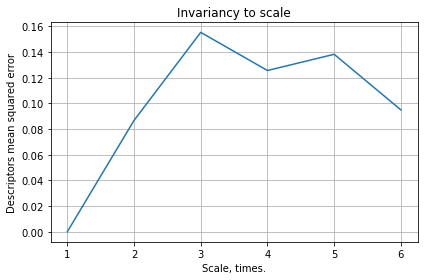

In [159]:
max_scale = 6
n = 6
scale_levels = np.zeros(n)
mean_stds = np.zeros(n)
scale_step = max_scale / n
for i in range(0, n):
    scale = 1 + i * scale_step
    image2 = transform.rescale(image, scale, multichannel=False)
    descriptor2, visualize2, gradient_orientations2, coms2 = daisy(image2, point, R, Q, T, H, SIGMAS, NORM)
    desc_norm = max(np.max(descriptor), np.max(descriptor2))
    mean_stds[i] = (((descriptor - descriptor2) / desc_norm) ** 2).mean()
    scale_levels[i] = scale
    
plot_xy(scale_levels, mean_stds, 
        title='Invariancy to scale', 
        xlabel='Scale, times.',
        ylabel='Descriptors mean squared error')

### Testing effects of intensity changes

*This part needs additional work*

To test invariancy changes in intensity, we will shrink image dynamic diapazone and on each step compare descriptor for it's center point with initial by calculating mean squared error.

For example, image with shrinked down dynamic diapazone looks like this:

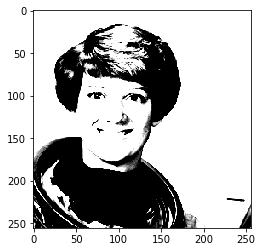

In [147]:
image2 = rescale_intensity(image, (0.45, 0.55))
imgshow(image2)

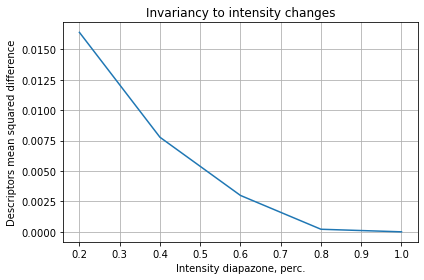

In [157]:
initial_intensity = [0, 1]
n = 5
int_levels = np.zeros(n)
mean_stds = np.zeros(n)
int_step = initial_intensity[1] / 2 / n
for i in range(0, n):
    intenity = i * int_step
    low = initial_intensity[0]+intenity
    high = initial_intensity[1]-intenity
    image2 = rescale_intensity(image, (low, high))
    descriptor2, visualize2, gradient_orientations2, coms2 = daisy(image2, point, R, Q, T, H, SIGMAS, NORM)
    desc_norm = max(np.max(descriptor), np.max(descriptor2))
    mean_stds[i] = (((descriptor - descriptor2) / desc_norm) ** 2).mean()
    perc = float(high - low)
    int_levels[i] = perc
    
plot_xy(int_levels, mean_stds, 
        title='Invariancy to intensity changes', 
        xlabel='Intensity diapazone, perc.',
        ylabel='Descriptors mean squared difference')

## Next steps
We will add more examples and tests for descriptors, and test on a greater scale with large numbers of points.